# 1. Import libraries

In [1]:
import pandas as pd

import numpy as np
import torch as T
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_helper_functions import *

# 2. Import data

In [2]:
link = "data/transfusion.data"
df = pd.read_csv(link)
# df = df.drop("Monetary (c.c. blood)", axis=1)
# df["Donation per month"] = df["Frequency (times)"] / df["Time (months)"]
# df["Months per donation"] = df["Time (months)"] / df["Frequency (times)"]
# df = df.drop("Time (months)", axis=1)
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
# separate exog and endog variables
y_var = "whether he/she donated blood in March 2007"
y = df[y_var]
X = df.drop(y_var, axis=1, inplace=False)

# 3. Preprocess data

In [4]:
# X["Recency (months)"] = X["Recency (months)"].clip(upper=30)
# Train test split
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, random_state=42)

def divide_columns(X):
    # return (X[..., 1] / (X[..., 0] + 1)).reshape(-1, 1)
    output = (X.iloc[:, 1] / (X.iloc[:, 0] + 1))
    return pd.DataFrame(output)

select_columns = ColumnTransformer(transformers=[
    ("select", "passthrough", ["Frequency (times)"]),
    ("clip", FunctionTransformer(lambda x: x.clip(upper=30)), ["Recency (months)"]),
    ("divide", FunctionTransformer(
        divide_columns,
        # feature_names_out="one-to-one"
        ), ["Frequency (times)", "Time (months)"])
], remainder="drop")


preprocessing_pipe = Pipeline(
    [
        ("select_columns", select_columns),
        ("standard_scaler", StandardScaler())
    ]
)


In [5]:
X_train_pipe_output = preprocessing_pipe.fit_transform(X_train_df)
X_test_pipe_output = preprocessing_pipe.transform(X_test_df)
X_train = T.tensor(X_train_pipe_output, dtype=T.float)
X_test = T.tensor(X_test_pipe_output, dtype=T.float)
y_train = T.tensor(y_train.to_numpy(), dtype=T.float).unsqueeze(-1)
y_test = T.tensor(y_test.to_numpy(), dtype=T.float).unsqueeze(-1)

In [6]:
X_train_pipe_output

array([[ 0.53522208, -0.06658136, -1.04725063],
       [-0.44176139, -0.06658136, -0.6114351 ],
       [-0.44176139,  1.55742477,  0.0766947 ],
       ...,
       [ 0.86088324,  0.88075555, -0.64966453],
       [ 0.20956092,  0.88075555,  1.25224977],
       [ 0.53522208, -0.74325057, -0.4967468 ]], shape=(561, 3))

# 4. Create model

In [21]:
model = SimpleClassifier(X_train.shape[-1], 64)

# 5. Prepare iterator

In [22]:
# Create train and test datasets
train_dt = CustomDataset(X_train, y_train)
test_dt = CustomDataset(X_test, y_test)

# Compute class counts
class_sample_counts = np.bincount(y_train.numpy().flatten().astype(int))
print(class_sample_counts)

# Compute class weights (inverse frequency)
weights = 1. / class_sample_counts

# Assign a weight to each sample
sample_weights = weights[y_train.numpy().flatten().astype(int)]

# Create sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dt, batch_size=BATCH_SIZE, sampler=sampler)
# train_dataloader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dt, batch_size=1024)

[431 130]


# 6. Create functions for training and parameters

In [23]:
optimizer = Adam(model.parameters(), lr=0.0002, weight_decay=0.0001)
loss_fn = nn.BCEWithLogitsLoss()
early_stopper = EarlyStopping(patience=20)

epochs = 10000

smoothing = True

train_losses = []
show_step = 10

# 7. Training

In [24]:
for epoch in range(epochs):
    for batch_x, batch_y in train_dataloader:
        batch_y_smoothed = smooth_labels(batch_y, smoothing=0.1)
        logits = model(batch_x)
        loss = loss_fn(logits, batch_y_smoothed if smoothing else batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        train_losses.append(loss.item())
        
    if epoch % show_step == 0:
        # for batch_x, batch_y in test_dataloader:
        logits = model(X_test).detach()
        loss = loss_fn(logits, y_test)
            
            
        print(
            f"Epoch: {epoch}, train_loss {np.mean(train_losses):.4f}, test_loss {loss.item():.4f}"
            )
        evaluate_model(y_test[:, 0], y_pred=T.sigmoid(logits[:, 0]))
        train_losses = []
        train_accuracy = []
        early_stopper(loss.item(), deepcopy(model.state_dict()))

        if early_stopper.early_stop:
            print("Early stopping triggered.")
            model.load_state_dict(early_stopper.state_dict)
            print(f"Best model loaded with loss {early_stopper.best_score:.4f}")
            break

Epoch: 0, train_loss 0.6697, test_loss 0.6713
Accuracy: 0.6150
F1 Score: 0.5200
AUC 0.7502
Epoch: 10, train_loss 0.6301, test_loss 0.6039
Accuracy: 0.6364
F1 Score: 0.5211
AUC 0.7613
New best score 0.603891
Epoch: 20, train_loss 0.6106, test_loss 0.5852
Accuracy: 0.6524
F1 Score: 0.5324
AUC 0.7598
New best score 0.585207
Epoch: 30, train_loss 0.6123, test_loss 0.5954
Accuracy: 0.6631
F1 Score: 0.5401
AUC 0.7571
Epoch: 40, train_loss 0.6093, test_loss 0.5875
Accuracy: 0.7112
F1 Score: 0.5645
AUC 0.7571
Epoch: 50, train_loss 0.6000, test_loss 0.5923
Accuracy: 0.6631
F1 Score: 0.5401
AUC 0.7591
Epoch: 60, train_loss 0.5998, test_loss 0.6085
Accuracy: 0.6631
F1 Score: 0.5401
AUC 0.7606
Epoch: 70, train_loss 0.5953, test_loss 0.5846
Accuracy: 0.7112
F1 Score: 0.5645
AUC 0.7631
New best score 0.584563
Epoch: 80, train_loss 0.5907, test_loss 0.5776
Accuracy: 0.7273
F1 Score: 0.5785
AUC 0.7624
New best score 0.577642
Epoch: 90, train_loss 0.5978, test_loss 0.5938
Accuracy: 0.7166
F1 Score: 0.5

# 8. Error analysis

In [25]:
X_val = X_test_df.copy()
X_val['y_pred'] = T.sigmoid(logits[:, 0])
X_val['y_true'] = y_test
X_val.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),y_pred,y_true
580,2,1,250,2,0.449943,0.0
356,16,6,1500,40,0.329274,0.0
133,4,6,1500,35,0.701317,0.0
250,11,2,500,11,0.474105,0.0
299,14,2,500,14,0.356788,0.0


In [26]:
X_val.iloc[np.argsort(cosine_similarity(X_test)[X_val.index.get_loc(511)])[-20:][::-1]]

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),y_pred,y_true
511,2,11,2750,26,0.879173,0.0
31,4,10,2500,28,0.808720,1.0
97,4,9,2250,38,0.770479,1.0
7,1,12,3000,35,0.882286,0.0
33,4,9,2250,26,0.819747,1.0
56,4,8,2000,26,0.819349,1.0
2,1,16,4000,35,0.888352,1.0
30,1,14,3500,58,0.808586,0.0
541,2,10,2500,52,0.759256,0.0
39,4,7,1750,22,0.825442,1.0


In [27]:
X_val.sort_values(["y_pred"], axis=0, ascending=False).head(10)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),y_pred,y_true
2,1,16,4000,35,0.888352,1.0
6,2,7,1750,14,0.886571,1.0
7,1,12,3000,35,0.882286,0.0
511,2,11,2750,26,0.879173,0.0
23,2,6,1500,16,0.857632,1.0
60,2,7,1750,29,0.828987,0.0
39,4,7,1750,22,0.825442,1.0
33,4,9,2250,26,0.819747,1.0
56,4,8,2000,26,0.819349,1.0
28,4,5,1250,11,0.816573,1.0


In [28]:
y_pred = T.sigmoid(model(X_test)).detach()
# Final metrics
evaluate_model(y_test[:, 0], y_pred=y_pred[:, 0])

Accuracy: 0.7273
F1 Score: 0.5143
AUC 0.7583


# 9. Point Explainer

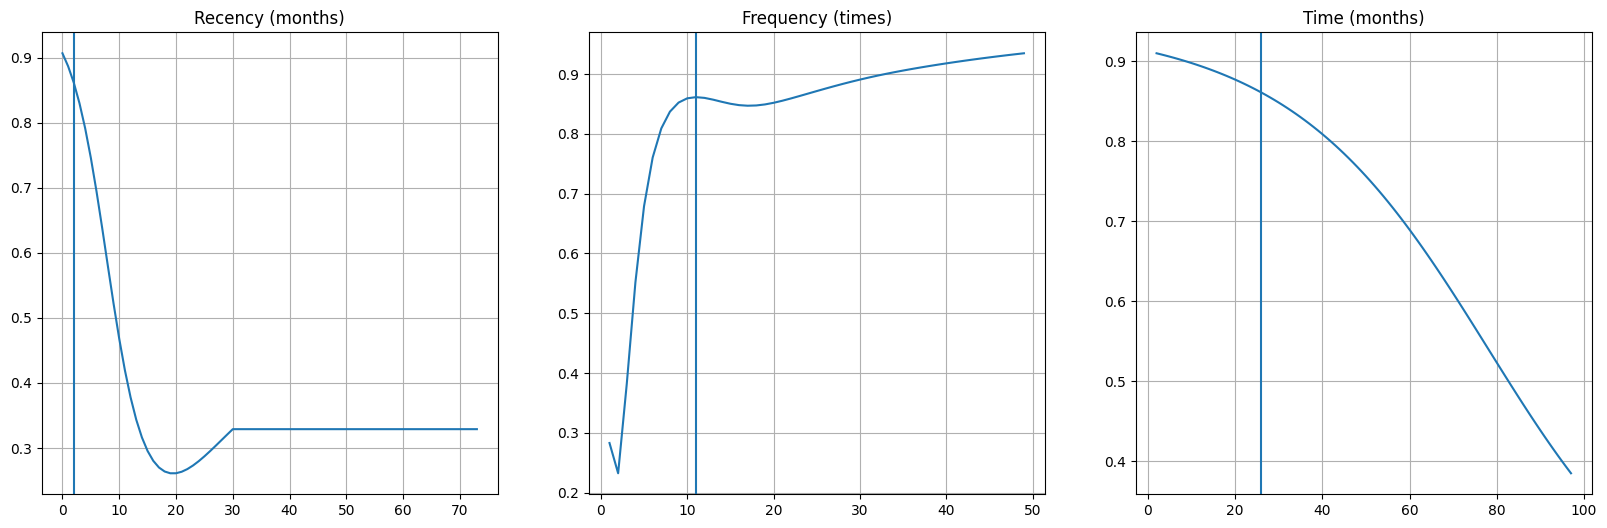

In [29]:
idx = 511
base_df = X_test_df.loc[[idx]]
list_ = []

valid_columns = ['Recency (months)',
 'Frequency (times)',
 'Time (months)']

fig, ax = plt.subplots(1, len(valid_columns), figsize=(20,6))

for n, col in enumerate(valid_columns):
    temp_list = []
    max_value = X_train_df[col].max()
    min_value = X_train_df[col].min()
    temp_df = base_df.copy()
    if X_train_df[col].dtype == "int":
        iterator = range(min_value, max_value)
        
    for i in iterator:
        temp_df[col] = i
        with T.no_grad():
            tens = preprocessing_pipe.transform(temp_df)
            tens = T.tensor(tens, dtype=T.float)
            y_pred = T.sigmoid(model(tens))
        temp_list.append((i, y_pred.mean()))
        
    x, y = zip(*temp_list)
    ax[n].plot(x, y)  # or use plt.scatter(x, y)
    # ax[n].xlabel("X axis")
    # ax[n].ylabel("Y axis")
    ax[n].axvline(x=base_df[col].to_numpy()[0])
    ax[n].set_title(col)
    ax[n].grid(True)
    list_.append(temp_list)
    
plt.show()
plt.close()

Cross impacts

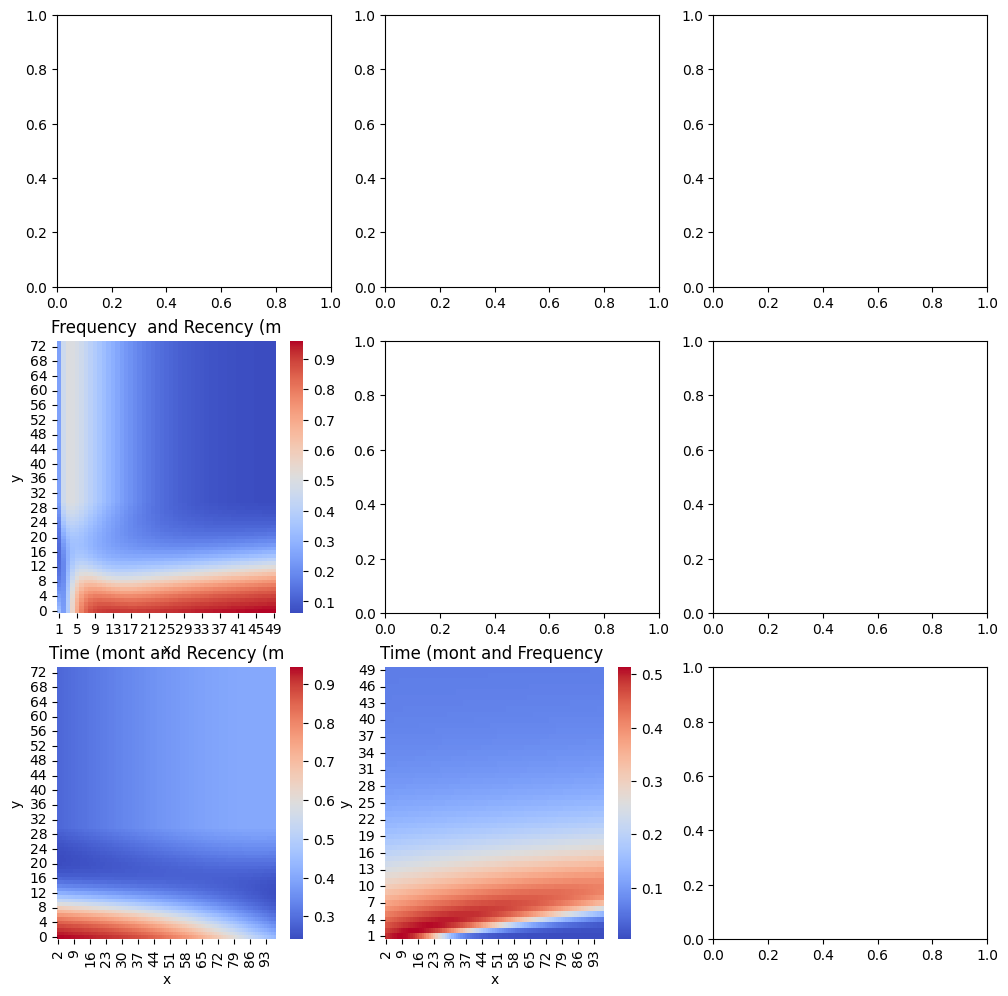

In [31]:
idx = 511
base_df = X_test_df.loc[[idx]]
list_ = []

fig, ax = plt.subplots(len(valid_columns), len(valid_columns), figsize=(12,12))

for n1, col1 in enumerate(valid_columns):
    
    temp_df = base_df.copy()
    max_value = X_train_df[col1].max()
    min_value = X_train_df[col1].min()
    if X_train_df[col1].dtype == "int":
        iterator1 = range(min_value, max_value)
    
    for n2, col2 in enumerate(valid_columns):
        # so it weren't any duplicates
        if n1 > n2:
            temp_list = []
            max_value = X_train_df[col2].max()
            min_value = X_train_df[col2].min()
            
            if X_train_df[col2].dtype == "int":
                iterator2 = range(min_value, max_value)
            
            for i1 in iterator1:
                for i2 in iterator2:
                    temp_df[col1] = i1
                    temp_df[col2] = i2
                    with T.no_grad():
                        tens = preprocessing_pipe.transform(temp_df)
                        tens = T.tensor(tens, dtype=T.float)
                        y_pred = T.sigmoid(model(tens))
                    temp_list.append((i1, i2, y_pred.mean().item()))
                
        else:
            temp_list = None
    
    
        if temp_list:
            df = pd.DataFrame(temp_list, columns=["x", "y", "value"])
            heatmap_data = df.pivot(index='y', columns='x', values='value')  # flip x/y for display
            sns.heatmap(heatmap_data, ax=ax[n1, n2], cmap="coolwarm", annot=False)
            ax[n1, n2].invert_yaxis()
            ax[n1, n2].set_title(f"{col1[:10]} and {col2[:10]}")
            list_.append((col1, col2, temp_list))
        
    
plt.show()
plt.close()